In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1)

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # convolution block 1        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),

            nn.Conv2d(8, 8, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)

        )

        # convolution block 2
        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(8, 8, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)

        )

        # transition block 1
        self.transition_1 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )
        
        # convolution block 3
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05), 

            nn.Conv2d(16, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05), 

            nn.Conv2d(16, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05), 

            nn.Conv2d(16, 10, 1),  
        
        )
        

        # output block
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) 

        # fully connected
#        self.fc1 = nn.Linear(16,10)


    def forward(self, x):

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.transition_1(x)
        x = self.conv_block_3(x)
 
        # GAP 
#        x = F.adaptive_avg_pool2d(x, (4, 4))  # Input - 7x7x32 -> Output - 1x1x32
        x = self.gap(x)


# #        reshape using flatten
#         x = torch.flatten(x, 1)

# #        Fully connected layer
#         x = self.fc1(x) # 1x1x32 -> 1x1x10


        x = x.view(-1, 10)

        return F.log_softmax(x,dim=-1)

In [4]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
             ReLU-10            [-1, 8, 22, 22]               0
      BatchNorm2d-11            [-1, 8, 22, 22]              16
          Dropout-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

In [6]:
#torch.manual_seed(1)
batch_size = 128
#added reguralisation

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.RandomCrop(28 , padding = 1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

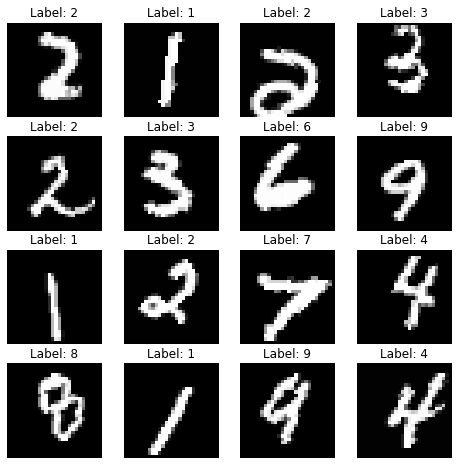

In [7]:
def show_batch(dl):
    images, labels = next(iter(dl))
    plt.figure(figsize=(8, 8))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(torch.squeeze(images[i], axis=0), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')

show_batch(train_loader)

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    model.train()
    pbar = tqdm(train_loader)
    per_batch_loss = []

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)          
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        per_batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
#        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    
    per_epoch_loss = sum(per_batch_loss)/len(per_batch_loss)
    per_epoch_accuracy = 100.*( correct / len(train_loader.dataset))
    
    return per_epoch_loss, per_epoch_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))


    return test_loss , 100. * correct / len(test_loader.dataset)


In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9) 

loss_train = []
accuracy_train = []
loss_test = []
accuracy_test = []
epochs = 15

for epoch in range(0, epochs):
    print('============== EPOCH ', epoch)
    loss_train_epoch,accuracy_train_epoch = train(model, device, train_loader, optimizer, epoch)
    loss_test_epoch, accuracy_test_epoch = test(model, device, test_loader)
    
    loss_train.append(loss_train_epoch)
    accuracy_train.append(accuracy_train_epoch)

    loss_test.append(loss_test_epoch)
    accuracy_test.append(accuracy_test_epoch)

    print(f'\t Train accuracy : {accuracy_train_epoch} , Test Accuracy: {accuracy_test_epoch}')
    print(f'\t Train Loss: {loss_train_epoch} , Test Loss: {loss_test_epoch}')
    

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_train,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_test,'-x')
    plt.legend(['train_loss', 'test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')


def plot_accuracy(train_acc, test_acc):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),train_acc,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),test_acc,'-x')
    plt.legend(['train_acc', 'test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')



  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 86.41499999999999 , Test Accuracy: 98.36
	 Train Loss: 0.4840441156806214 , Test Loss: 0.056074824714660645
============== EPOCH  1
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 96.14166666666667 , Test Accuracy: 98.7
	 Train Loss: 0.13444045461269458 , Test Loss: 0.04208812284469605
============== EPOCH  2
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 96.78666666666666 , Test Accuracy: 98.9
	 Train Loss: 0.10874799061526876 , Test Loss: 0.03326067638397217
============== EPOCH  3
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 97.175 , Test Accuracy: 99.09
	 Train Loss: 0.09413978097829293 , Test Loss: 0.029081395936012267
============== EPOCH  4
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 97.48833333333333 , Test Accuracy: 99.08
	 Train Loss: 0.08336994672285468 , Test Loss: 0.02945825273990631
============== EPOCH  5
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 97.5

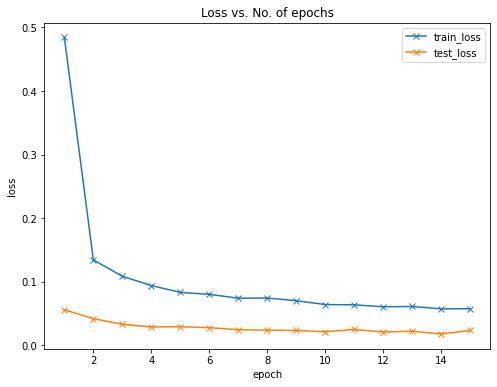

In [10]:
plot_loss(loss_train,loss_test)

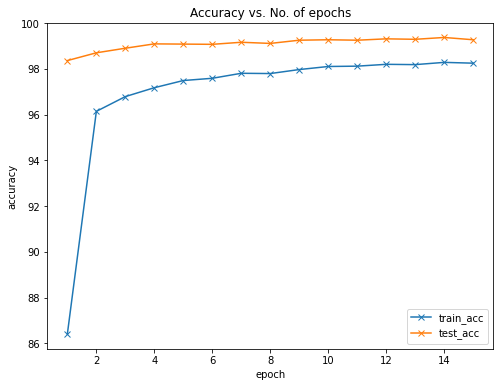

In [11]:
plot_accuracy(accuracy_train,accuracy_test)

Target:  
    
    Aim to reduce capacity of model to avoid overfitting.

Info:

    Reguralised model with:
        1. Reducing parameters (removing bias, and additional convolution layer)
        2. Introducing Dropout
        3. Introducing Augmentation
        4. GAP, used pointwise as final output layer before GAP

Result:
        Parameters: 7.3k  
        Best Training Accuracy: 98.28  
        Best Test Accuracy: 99.37  

Analysis:

        We see that model is underfitting!
        Because we tried to reduce capacity, introduced dropout, Augmentation all at once. Which had combined effect of lowering the training accuracy 

        We reached 99.39 once, hence maybe use LR_scheduler for even loss 

        In next attempt, we will remove these excessive reguralisation 
        
